In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'


2025-05-05 15:50:16.293555: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 15:50:17.525206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746481817.810433   69194 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746481817.921286   69194 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 15:50:18.767511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [41]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='10:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(25)

# Setup your client
client = Client(cluster)

/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43183 instead
  warnings.warn(


In [42]:
client.shutdown()

### setup

In [2]:
def get_biome_param_names(b, u_params, pft_params):
    
    with open(utils_path+"/biome_configs.pkl", "rb") as f:
        biome_configs = pickle.load(f)

    param_names = list(u_params)
    for pft in biome_configs[b]['pfts']:
        pft_param_names = [f"{param}_{pft}" for param in pft_params]
        param_names.extend(pft_param_names)

    return param_names

In [3]:
#======================== set up ============================
# get parameter information
with open(utils_dir+"/param_names.pkl", "rb") as f:
    param_info = pickle.load(f)
u_params = param_info['u_params']
pft_params = param_info['pft_params']

# get biome information
with open(utils_dir+"/biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)

# get default parameter set and reset some settings of default parameters
default_params = pd.read_csv('default_params_norm.csv', index_col=False)
default_params.loc[0, ['jmaxb1']] = [0.4]
default_params.loc[0, ['theta_cj']] = [0.7]
default_params.loc[0, ['upplim_destruct_metamorph']] = [1]
default_params.loc[0, ['xl_12']] = [0]

# Build universal_set tensor
universal_set = tf.constant(default_params[u_params].iloc[[0]].to_numpy(),dtype=tf.float64)

x_default = tf.constant(default_params.drop(columns=u_params).iloc[[0]].to_numpy(), dtype=tf.float64)


2025-05-05 15:51:06.870692: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [35]:
# get observations & tweek 
obs = xr.open_dataset(utils_path + 'wave2_obsStatistics_sudokuBiomes.nc')
obs_biome = obs.copy()

# use GIMMS for LAI instead of the multiproduct mean
gimms = xr.open_dataset('../data/sudoku_biomes/biome_laimax_obs.nc')
obs_biome['LAI_mean'].values = np.concatenate([[0],gimms.GIMMS_biome_laimax.values])
obs_biome['LAI_mean'].loc[{'biome': 2}] = 3
obs_biome['LAI_mean'].loc[{'biome': 3}] = 4
obs_biome['LAI_mean'].loc[{'biome': 7}] = 4
obs_biome['LAI_mean'].loc[{'biome': 8}] = 3

# increase the tolerance for biomass by inflating the stdev
obs_biome['biomassC_stdev'].values = obs_biome['biomassC_mean'].values*0.2

#set stdev so high the optimization ignores this biome/variable
obs_biome['biomassC_stdev'].loc[{'biome': 12}] = 100


In [36]:
paths = {
    'lai': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomelai_compiled/',
    'gpp': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomegpp_compiled/',
    'biomass': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomebiomass_compiled/'
}

biomes = [1,2,3,4,5,6,7,8,9,10,11,12,13]
param_indices = []
targets = []
stdevs = []
emulators = []  

for b in biomes:
    biome_name = biome_configs[b]['name']
    param_names = get_biome_param_names(b,u_params,pft_params)
    param_ix = [default_params.columns.get_loc(p)for p in param_names]
    
    param_indices.append(param_ix)
    param_indices.append(param_ix)
    param_indices.append(param_ix)
    
    targets.extend([
        tf.convert_to_tensor(obs_biome.LAI_mean.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.GPP_mean.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.biomassC_mean.isel(biome=b).values, dtype=tf.float64)
    ])
    stdevs.extend([
        tf.convert_to_tensor(obs_biome.LAI_stdev.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.GPP_stdev.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.biomassC_stdev.isel(biome=b).values, dtype=tf.float64)
    ])

    emulators.extend([
        tf.saved_model.load(f"{paths['lai']}{biome_name}"),
        tf.saved_model.load(f"{paths['gpp']}{biome_name}"),
        tf.saved_model.load(f"{paths['biomass']}{biome_name}")
    ])
    
targets = tf.stack(targets, axis=0)  
stdevs = tf.stack(stdevs, axis=0)   


In [37]:
# ——— for fast graph execution ———
lengths = [len(arr) for arr in param_indices]     # list of Python ints

emulator_array = []
for m,input_dim in zip(emulators, lengths):
    sig = tf.TensorSpec([None, input_dim], tf.float64)
    f = tf.function(lambda X, _m=m: _m.compiled_predict_f(X)[0], input_signature=[sig])
    emulator_array.append(f)

### Functions

In [38]:

@tf.function
def optimization_step_batch(x, universal_set, emulator_array, param_indices, optimizer, x_default, barrier_strength=1, lambda_penalty=0.01):
    with tf.GradientTape() as tape:
        batch = tf.shape(x)[0]
        u_tiled = tf.tile(universal_set, [batch, 1])   
        x_full = tf.concat([u_tiled, x], axis=1)
        per_model_losses = []
        
        # loop over metrics and biomes in stacked 1D arrays. 
        for i in range(len(emulator_array)):
            model   = emulator_array[i]

            target = tf.reshape(targets[i], (1, -1))
            stdev = tf.reshape(stdevs[i], (1, -1))
            target_tiled = tf.tile(target, [batch, 1])
            stdev_tiled = tf.tile(stdev, [batch, 1])
        
            ix  = param_indices[i]          
            x_biome = tf.gather(x_full, ix, axis=1)
            y_pred = model(x_biome)
            z = tf.abs((y_pred - target_tiled)/stdev_tiled)

            if epsilon is not None: # if biome/variable zscore is < epsilon, it no longer contributes to loss
                mask = tf.cast(z > epsilon, tf.float64)
                loss_b = tf.reduce_sum(mask * tf.square(z), axis=1)
            else:
                loss_b = tf.reduce_sum(tf.square(z), axis=1)
            
            # size [batch]
            per_model_losses.append(loss_b)
            
        loss_per_sample = tf.add_n(per_model_losses)
        data_loss = tf.reduce_mean(loss_per_sample) # overall scalar loss = mean of the batch
        max_z = tf.sqrt(tf.reduce_max(loss_per_sample)) # worst individual biome/init zscore

        # Penalty for moving from default
        # sum over the parameter‐axis (axis=1) → shape [batch]
        x_default_tiled = tf.tile(x_default, [batch, 1])
        sum_abs = tf.reduce_sum(tf.abs(x - x_default_tiled), axis=1)
        penalty = tf.reduce_mean(sum_abs) # mean of batch

        ratio = penalty / lambda_penalty
        factor = tf.maximum(ratio, 1.0) # if the penalty ==lambda, it no longer impacts loss
        total_loss = data_loss * factor
        
        # penalty for being close to/outside of bounds (0,1)
        barrier = tf.reduce_mean(1.0 / (x + 1e-6) + 1.0 / (1.0 - x + 1e-6))
        total_loss = total_loss * (1.0 + barrier_strength * barrier)
        
    grads = tape.gradient(total_loss, [x])
    optimizer.apply_gradients(zip(grads, [x]))
    x.assign(tf.clip_by_value(x, 0.0, 1.0))
    return total_loss, max_z, data_loss, factor, barrier_strength*barrier

In [39]:

def run_optimization(x, universal_set, emulator_array, param_indices, x_default, maxiter, lr, lr_decay_steps, checkpoint_N, checkpoint_dir, epsilon, barrier_strength, lambda_penalty=0.0):
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=lr_decay_steps,
        decay_rate=0.5,
        staircase=True)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    history_total_loss = []
    history_max_z = []
    history_data_loss = []
    history_penalty = []
    history_barrier = []
    
    for step in range(maxiter):

        total_loss, max_z, data_loss, penalty, barrier_loss = optimization_step_batch(x, universal_set, emulator_array, param_indices, optimizer, x_default, barrier_strength, lambda_penalty)

        # log
        history_total_loss.append(total_loss.numpy())
        history_max_z.append(max_z.numpy())
        history_data_loss.append(data_loss.numpy())
        history_penalty.append(penalty.numpy())
        history_barrier.append(barrier_loss.numpy())

        # print updates to screen
        if step % 10 == 0:
            tf.print(f"Step {step:03d}: total={total_loss:.6f} max_z={max_z:.6f}")
    
        # Save a checkpoint every N iterations
        if step % checkpoint_N == 0:
            checkpoint = {
                'step': step,
                'params': x,
                'loss': total_loss,
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_step_{step}.pkl')
            with open(checkpoint_path, 'wb') as f:
                pickle.dump(checkpoint, f)
                
        # early stopping
        if tf.reduce_max(max_z) <= epsilon:
            print(f"Converged at step {step}")
            tf.print(f"Step {step:03d}: total={total_loss:.6f} max_z={max_z:.6f}")
            break
    
    x_opt = x.numpy()
    logs = {
        'total_loss': history_total_loss,
        'max_z': history_max_z,
        'data_loss': history_data_loss,
        'penalty': history_penalty,
        'barrier': history_barrier
    }
    
    return x_opt, logs

### initialization

In [40]:
# initialization version 2: sample from normal priors around default
pft_cols     = [c for c in default_params.columns if c not in u_params]
default_pftparams = default_params[pft_cols].iloc[0].values   

n_inits = 1000
sigma   = 0.1   # spread of your normal draws

np.random.seed(42)   # for reproducibility, optional
x0 = np.random.normal(loc=default_pftparams,
                      scale=sigma,
                      size=(n_inits, default_pftparams.size))

# enforce bounds [0,1]
x0 = np.clip(x0, 0.0, 1.0)

x_init = tf.Variable(
    tf.constant(x0, dtype=tf.float64),
    trainable=True,
    name="x"
)

In [9]:
# =========================== save ======================================
n_inits = np.shape(x0)[0]
uset_tiled = np.tile(default_params[u_params].values[0], (n_inits,1))
init_sets = np.concatenate([uset_tiled,x0],axis=1)
init_paramsets = pd.DataFrame(init_sets,columns=default_params.columns.values)

outfile = 'init_sets_defaultPrior.csv'
init_paramsets.to_csv(outfile,index=False)

In [10]:
with open("./checkpoints_PhilosophyA/checkpoint_step_990.pkl", "rb") as f:
    c0 = pickle.load(f)

x_init = tf.Variable(
    tf.constant(c0['params'], dtype=tf.float64),
    trainable=True,
    name="x"
)

### calibration

In [14]:
%%time
# Run optimization
epsilon = 0.5
lr = 1e-2
maxiter=1500
lr_decay_steps = 300
checkpoint_N = 10
checkpoint_dir = './checkpoints_PhilosophyA_v2/'
lambda_penalty = 14 # worst sum of delta from default you will tolerate
barrier_strength = 0 # clipping is on

x_opt, logs = run_optimization(x_init, universal_set, emulator_array, param_indices, x_default, 
                               maxiter, lr, lr_decay_steps, checkpoint_N, checkpoint_dir, epsilon, barrier_strength, lambda_penalty)

Step 000: total=11.116113 max_z=3.735344
Step 010: total=9.624978 max_z=3.669635
Step 020: total=7.506643 max_z=3.133071
Step 030: total=6.695632 max_z=2.991618
Step 040: total=6.110387 max_z=2.921524
Step 050: total=5.666334 max_z=2.983864
Step 060: total=5.267394 max_z=2.739229
Step 070: total=4.897258 max_z=2.660993
Step 080: total=4.640694 max_z=2.626331
Step 090: total=4.447593 max_z=2.587409
Step 100: total=4.265420 max_z=2.495789
Step 110: total=4.000062 max_z=2.346356
Step 120: total=3.799230 max_z=2.367590
Step 130: total=3.627924 max_z=2.384594
Step 140: total=3.485332 max_z=2.318728
Step 150: total=3.338458 max_z=2.303925
Step 160: total=3.166341 max_z=2.213913
Step 170: total=3.105810 max_z=2.283388
Step 180: total=3.034248 max_z=2.190793
Step 190: total=2.910636 max_z=2.144806
Step 200: total=2.835250 max_z=2.311241
Step 210: total=2.743683 max_z=2.168386
Step 220: total=2.730009 max_z=2.112813
Step 230: total=2.656338 max_z=2.217717
Step 240: total=2.601217 max_z=2.083570

In [16]:
# =========================== save ======================================
n_inits = np.shape(x_opt)[0]
uset_tiled = np.tile(default_params[u_params].values[0], (n_inits,1))
opt_sets = np.concatenate([uset_tiled,x_opt],axis=1)
calibrated_paramsets = pd.DataFrame(opt_sets,columns=default_params.columns.values)

outfile = checkpoint_dir+'calibrated_sets_defaultPrior_lambda20_050425.csv'
calibrated_paramsets.to_csv(outfile,index=False)

### plot convergence logs

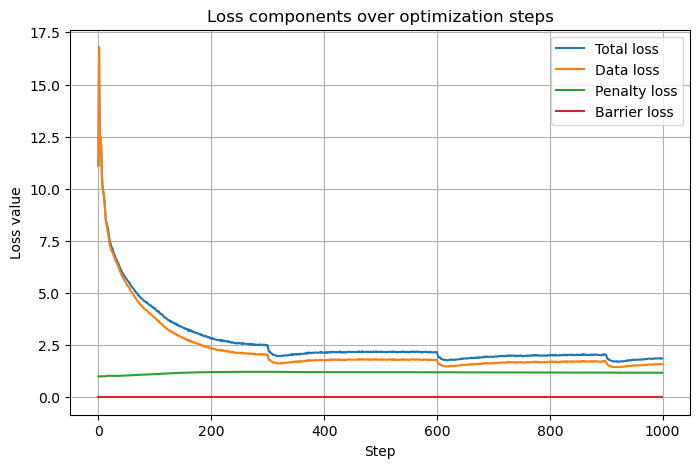

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(logs['total_loss'], label='Total loss')
plt.plot(logs['data_loss'], label='Data loss')
plt.plot(logs['penalty'], label='Penalty loss')
plt.plot(logs['barrier'], label='Barrier loss')
plt.xlabel('Step')
plt.ylabel('Loss value')
plt.legend()
plt.grid(True)
plt.title('Loss components over optimization steps')
#plt.ylim(0,10)
plt.show()


In [19]:
d_tiled = np.tile(default_params.drop(columns=u_params).values[0], (n_inits,1))
np.sum(np.abs(x_opt - d_tiled),axis=1)

array([37.54257205, 37.07123646, 37.29671792, 37.56807114, 30.07235547,
       36.58240021, 36.51289136, 37.67021909, 30.44253541, 36.92162633,
       37.01518134, 36.84218504, 28.95350301, 35.36166667, 36.27647139,
       31.10603472, 36.45258097, 29.81933739, 28.65090342, 37.50173745,
       35.94847992, 37.30952792, 38.67995116, 30.63226236, 37.38392842,
       35.49093988, 39.00636775, 35.36195622, 37.36149873, 37.42023369,
       28.9054493 , 36.23477121, 37.23388125, 36.54230056, 37.57102692,
       37.64641684, 37.46728231, 36.73552837, 29.01820458, 36.04383165,
       37.2621319 , 37.89224467, 36.92495303, 29.41251283, 29.59781162,
       37.40502814, 38.23043795, 37.42521152, 37.26446018, 36.49836085,
       37.42991308, 29.44236274, 35.83066519, 37.59503115, 36.76067832,
       36.19976534, 29.11389174, 29.83037153, 36.14312481, 30.95781436,
       30.70641436, 28.98703843, 36.52660265, 37.01494381, 29.65449782,
       29.61509004, 31.37861244, 36.61617094, 37.08304156, 37.85

### Plot posteriors

In [ ]:
full_calibrated_paramsets = pd.read_csv('calibrated_sets_unifRandom.csv')

In [ ]:
# Define LEAP colors
leap_colors = ['#B9D9EB', '#00796B', '#012169']

# Prepare data
pft = 4
pft_param_names = [f"{param}_{pft}" for param in pft_params]
data = full_calibrated_paramsets[pft_param_names]

n = len(pft_param_names)

# Set plot-wide styles
plt.rcParams.update({
    'font.size': 10,         # Font size
    'axes.labelsize': 12,    # Axis label size
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8,
    'axes.linewidth': 0.8,   # Thin frame lines
    'savefig.dpi': 300,
})

fig, axes = plt.subplots(n, n, figsize=(2*n, 2*n))  # Larger, scalable size

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        if i == j:
            # 1D histogram on the diagonal
            ax.hist(data[pft_param_names[i]], bins=50, color=leap_colors[2], alpha=0.7)
            ax.axvline(default_params[pft_param_names[i]].values)
            ax.set_xlim([0,1])
        else:
            # 2D hexbin on the off-diagonals
            hb = ax.hexbin(
                data[pft_param_names[j]],
                data[pft_param_names[i]],
                gridsize=50,
                #cmap='Blues',
                vmin=0,
                vmax=20,
                mincnt=1,           # Only show bins with data
                linewidths=0
            )
            # Fix hexbin color to LEAP navy color
            #hb.set_cmap('Blues')
            #hb.set_array(hb.get_array()*0+1)  # Uniform color intensity
            #hb.set_edgecolor('none')
            #hb.set_facecolor(leap_colors[2])  # Dark navy
            ax.axvline(default_params[pft_param_names[j]].values)
            ax.axhline(default_params[pft_param_names[i]].values)
            #ax.set_ylim([0,1])
            #ax.set_xlim([0,1])

        # Clean ticks
        if i < n-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(pft_param_names[j], fontsize=10)
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(pft_param_names[i], fontsize=10)

plt.tight_layout(pad=0.5)
#plt.savefig('./figs/hexbin_scattermatrix_pftparams_pft'+str(pft)+'.png', dpi = 300)

In [15]:
logs['penalty']

[39.19748610423464,
 34.74208605643806,
 31.0533170457477,
 28.07848845754855,
 25.75201064567405,
 24.002948467894115,
 22.761878489796153,
 21.962020944154865,
 21.538431862164845,
 21.431126831175046,
 21.586122228656986,
 21.95586542086044,
 22.49958441426443,
 23.181805973609077,
 23.971795912696216,
 24.845295042472788,
 25.78029721367061,
 26.758748107154787,
 27.76520428706409,
 28.787663962554305,
 29.818780795559505,
 30.849958417824514,
 31.877034060858648,
 32.89653630142642,
 33.904920581228126,
 34.900303829869735,
 35.88036374907937,
 36.842961020215874,
 37.785867689159446,
 38.70851073808008,
 39.60653624960008,
 40.47950465389614,
 41.32416071826179,
 42.14215547319547,
 42.93285113408188,
 43.69410084846617,
 44.42665008976809,
 45.12562522915323,
 45.794447964061895,
 46.43065652785542,
 47.03647134455201,
 47.61176166825982,
 48.15596891307426,
 48.67429188063457,
 49.16779784718529,
 49.63957858472188,
 50.0912600653993,
 50.524037652200434,
 50.939122228800066,
 

In [16]:
60/20

3.0

In [17]:
3/20

0.15